<a href="https://colab.research.google.com/github/SaidaAourras/EcoVolt/blob/main/EcoVolt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Préparation des données temporelles

In [8]:
%ls ../

bin@      dataset.csv  kaggle/  libx32@  proc/               run/   tmp/
boot/     dev/         lib@     media/   python-apt/         sbin@  tools/
content/  etc/         lib32@   mnt/     python-apt.tar.xz*  srv/   usr/
datalab/  home/        lib64@   opt/     root/               sys/   var/


In [9]:
import pandas as pd
df = pd.read_csv('../dataset.csv')
df["DateTime"] = pd.to_datetime(df["DateTime"])
df = df.sort_values("DateTime")
df.set_index("DateTime", inplace=True) # set the index to become the "DateTime" column

**Pourquoi l’ordre temporel est critique**

**Pourquoi on ne mélange pas les données (pas de shuffle)**

### 2. Normalisation des données

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaleddata = scaler.fit_transform(df)

**Pourquoi la normalisation
est indispensable en Deep Learning**

**Pourquoi MinMax est souvent préféré à StandardScaler pour LSTM**


### 3. Création des séquences

In [11]:
import numpy as np
def create_sequences(data, window=24):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i, 0])  # Consumption
    return np.array(X), np.array(y)
X, y = create_sequences(scaleddata, window=24)

**Pourquoi un LSTM attend des données en 3D**

**Signification de la forme : (samples, timesteps, features)**

### 4. Split Train / Test (temporel)

In [12]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

**Pourquoi on ne fait pas de traintestsplit classique**

**Risque de fuite de données temporelles**

### 5. Architecture LSTM

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
model = Sequential([
    LSTM(64, input_shape=(24, X.shape[2])),
    Dropout(0.2),
    Dense(1)
])
model.compile(
    optimizer="adam",
    loss="mse"
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


**Impact du nombre d’unités LSTM**

**Différence entre 1 ou plusieurs couches LSTM**

### 6. Entrainement & Monitoring

In [14]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32
)

Epoch 1/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - loss: 0.0143 - val_loss: 0.0016
Epoch 2/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.0029 - val_loss: 9.3588e-04
Epoch 3/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.0020 - val_loss: 7.2151e-04
Epoch 4/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - loss: 0.0014 - val_loss: 6.0851e-04
Epoch 5/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.0011 - val_loss: 5.7309e-04
Epoch 6/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 9.3722e-04 - val_loss: 5.5068e-04
Epoch 7/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 8.3946e-04 - val_loss: 4.8170e-04
Epoch 8/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 7.6259e-04 - val_loss: 3.9875e-04
Epoch 9/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 6.9019e-04 - val_loss: 3.9647e-04
Epoch 10/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 6.4943e-04 - val_loss: 4.4590e-04
Epoch 11/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 

**Courbe loss vs val_loss**

**Détection du surapprentissage**

### 7. Evaluation du modèle

339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


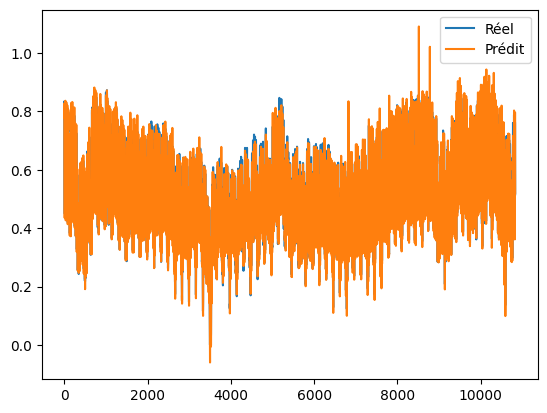

In [15]:
import matplotlib.pyplot as plt
y_pred = model.predict(X_test)
plt.plot(y_test, label="Réel")
plt.plot(y_pred, label="Prédit")
plt.legend()
plt.show()

### save graphs

In [16]:
from google.colab import drive
import matplotlib.pyplot as plt

# Monter Google Drive
drive.mount('/content/drive')

# Créer un dossier pour les images
import os
os.makedirs('/content/drive/MyDrive/EcoVolt/images', exist_ok=True)

# Sauvegarder le graphe
plt.figure(figsize=(12, 6))
# ... votre code de graphe ...
plt.savefig('/content/drive/MyDrive/EcoVolt/images/predictions_vs_actual.png',
            dpi=300, bbox_inches='tight')
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<Figure size 1200x600 with 0 Axes>